In [1]:
%pylab inline

import gc
import pdet
import fpfs
import fitsio
import pltutil
import numpy as np
import numpy.lib.recfunctions as rfn
import matplotlib.pylab as plt

Populating the interactive namespace from numpy and matplotlib
Do not have lsst pipeline!


In [2]:
# merge data from n fields
out1=[]
out2=[]
for _i in range(500):
    _a1=fitsio.read('../../../sim/src_basicCenter-var4em3/psf60/fpfs-cut16-%04d-g1-0000.fits' %_i)
    _a2=fitsio.read('../../../sim/src_basicCenter-var4em3/psf60/fpfs-cut16-%04d-g1-2222.fits' %_i)
    out1.append(_a1)
    out2.append(_a2)

In [3]:
out1 =   rfn.stack_arrays(out1,usemask=False)
out2 =   rfn.stack_arrays(out2,usemask=False)

Const=   8000.
outD1=   pdet.peak2det(out1)
outD2=   pdet.peak2det(out2)
outE1=   pdet.fpfsM2E(out1,outD1,const=Const,noirev=True)
outE2=   pdet.fpfsM2E(out2,outD2,const=Const,noirev=True)

outEU1=  fpfs.fpfsBase.fpfsM2E(out1,const=Const,noirev=True)
outEU2=  fpfs.fpfsBase.fpfsM2E(out2,const=Const,noirev=True)

del out1,out2
gc.collect()

0

In [4]:
def get_detbias(dets,ells,cut,dcc,ind):
    """
    Parameters:
        dets: 	    detection array
        cut:        selection cut
        dcc:        bin size when estimating marginal density
        inds:       shifting indexes
    """
    fnmv   =  'pdet_v%d%d'  %ind
    fnmr1  =  'fpfs_e1v%d%dr1'%ind
    fnmr2  =  'fpfs_e2v%d%dr2'%ind
    ll     =  cut;uu  =  cut+dcc
    msk    =  (dets[fnmv]>ll)&(dets[fnmv]<uu)
    cor1=np.sum(ells[fnmr1][msk])/dcc
    cor2=np.sum(ells[fnmr2][msk])/dcc
    return cor1,cor2

In [5]:
dcc=0.01
x=[]
y1=[]
y2=[]
tt=(2,2)
pn='v%d%d' %tt

if tt != (2,2):
    xlabel=r'$I_{\rm peak}-I_{\Delta %d%d}$' %(tt[0]-2,tt[1]-2)
else:
    xlabel=r'$I_{\rm peak}$'
for i in range(0,10):
    cut=0.2*i
    
    msk1 = (outD1['pdet_%s' %pn]>cut)
    ellM1= outE1[msk1]
    detM1= outD1[msk1]
    del msk1
    
    msk2 = (outD2['pdet_%s' %pn]>cut)
    ellM2= outE2[msk2]
    detM2= outD2[msk2]
    del msk2
    
    cor1 = get_detbias(detM1,ellM1,cut,dcc,ind=tt)[0]
    cor2 = get_detbias(detM2,ellM2,cut,dcc,ind=tt)[0]
    print(cor1)
    de   = np.sum(ellM2['fpfs_e1'])-np.sum(ellM1['fpfs_e1'])
    rave = (np.sum(ellM2['fpfs_RE'])+np.sum(ellM1['fpfs_RE']))/2.
    raveR= (np.sum(ellM2['fpfs_RE'])+np.sum(ellM1['fpfs_RE'])+cor1+cor2)/2.
    x.append(cut/np.sqrt(4e-3))
    y1.append(de/rave/0.04-1)
    y2.append(de/raveR/0.04-1)
    del ellM1,detM1,ellM2,detM2
gc.collect()

0.9221028142457158
4270.857036895275
13539.222800363646
18150.436320885
21031.88585076818
17990.098752128433
16858.849593544466
14223.954785758224
12884.524261346183
12727.494702454216


0

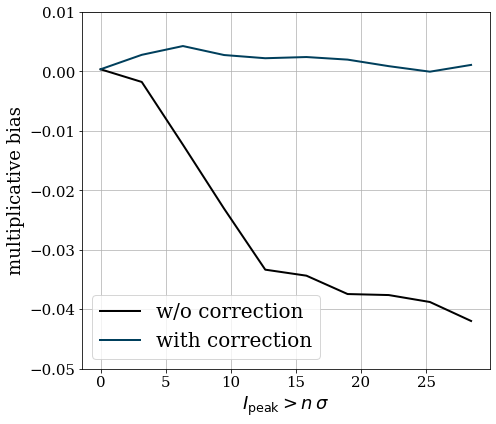

In [6]:
plt.close()
fig,axes=pltutil.make_figure_axes(1,1)
ax=axes[0]
ax.plot(np.array(x),np.array(y1),label='w/o correction',color=pltutil.colors[0])
ax.plot(np.array(x),np.array(y2),label='with correction',color=pltutil.colors[1])
ax.set_xlabel(xlabel+r'$>n\,\sigma$')
ax.set_ylabel('multiplicative bias')
ax.set_ylim(-0.05,0.01)
ax.grid()
ax.legend()
plt.tight_layout()
#fig.savefig('../../html/noisy_knownRef_%s.png' %pn)

In [7]:
dcc=0.02
x=[]
y1=[]
y2=[]
tt=(2,2)
pn='v%d%d' %tt

if tt != (2,2):
    xlabel=r'$I_{\rm peak}-I_{\Delta %d%d}$' %(tt[0]-2,tt[1]-2)
else:
    xlabel=r'$I_{\rm peak}$'
for i in range(0,10):
    cut=0.2*i
    
    msk1 = (outD1['pdet_%s' %pn]>cut)
    ellM1= outEU1[msk1]
    detM1= outD1[msk1]
    a=(ellM1['fpfs_e1']*detM1['pdet_v22r1']+ellM1['fpfs_e2']*detM1['pdet_v22r2'])/2.
    aa1={'fpfs_e1v22r1':a,
         'fpfs_e2v22r2':a}
    del msk1
    msk2 = (outD2['pdet_%s' %pn]>cut)
    ellM2= outEU2[msk2]
    detM2= outD2[msk2]
    del a
    a=(ellM2['fpfs_e1']*detM2['pdet_v22r1']+ellM2['fpfs_e2']*detM2['pdet_v22r2'])/2.
    aa2={'fpfs_e1v22r1':a,
         'fpfs_e2v22r2':a}
    del msk2
    cor1 = get_detbias(detM1,aa1,cut,dcc,ind=tt)[0]
    print(cor1)
    cor2 = get_detbias(detM2,aa2,cut,dcc,ind=tt)[0]
    de   = np.sum(ellM2['fpfs_e1'])-np.sum(ellM1['fpfs_e1'])
    rave = (np.sum(ellM2['fpfs_RE'])+np.sum(ellM1['fpfs_RE']))/2.
    raveR= (np.sum(ellM2['fpfs_RE'])+np.sum(ellM1['fpfs_RE'])+cor1+cor2)/2.
    x.append(cut/np.sqrt(4e-3))
    y1.append(de/rave/0.04-1)
    y2.append(de/raveR/0.04-1)
    del ellM1,detM1,ellM2,detM2,aa1,aa2
gc.collect()

1.6555105011900235
6541.400285736397
16715.26878008524
19601.790390487153
21426.845357129147
18788.546705765242
17332.29192915279
14724.217395876985
13142.150860819675
12436.146055139874


508

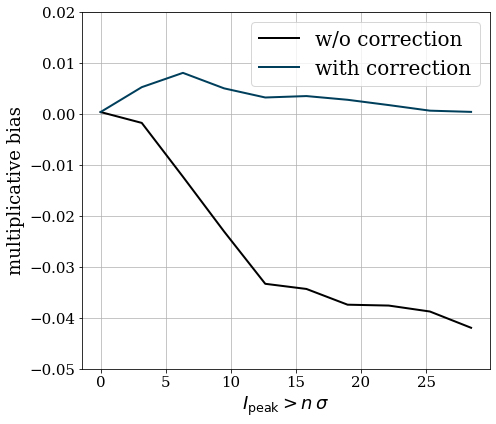

In [8]:
plt.close()
fig,axes=pltutil.make_figure_axes(1,1)
ax=axes[0]
ax.plot(np.array(x),np.array(y1),label='w/o correction',color=pltutil.colors[0])
ax.plot(np.array(x),np.array(y2),label='with correction',color=pltutil.colors[1])
ax.set_xlabel(xlabel+r'$>n\,\sigma$')
ax.set_ylabel('multiplicative bias')
ax.set_ylim(-0.05,0.02)
ax.grid()
ax.legend()
plt.tight_layout()
#fig.savefig('../../html/noisy_knownRef_%s.png' %pn)

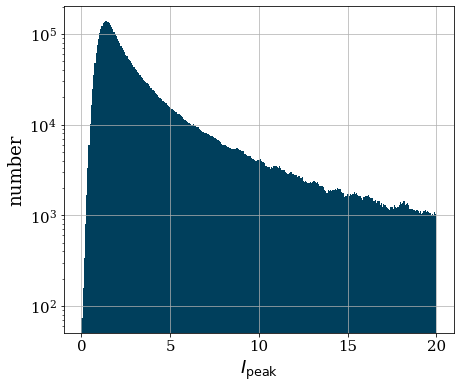

In [9]:
plt.close()
fig,axes=pltutil.make_figure_axes(1,1)
ax=axes[0]
ax.hist(outD1['pdet_%s' %pn]/0.2,range=(0,20),bins=300,color=pltutil.colors[1])
ax.set_yscale('log')
ax.set_xlabel(xlabel)
ax.set_ylabel('number')
ax.grid()